In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from xgboost import XGBClassifier



from scipy.stats import randint as sp_randint




im getting really good at this because ive had to re-do it 300 times :)

In [2]:
df = pd.read_csv("data/malware_vs_benign.csv")


In [3]:

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19611 entries, 0 to 19610
Data columns (total 79 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Name                          19611 non-null  object 
 1   e_magic                       19611 non-null  int64  
 2   e_cblp                        19611 non-null  int64  
 3   e_cp                          19611 non-null  int64  
 4   e_crlc                        19611 non-null  int64  
 5   e_cparhdr                     19611 non-null  int64  
 6   e_minalloc                    19611 non-null  int64  
 7   e_maxalloc                    19611 non-null  int64  
 8   e_ss                          19611 non-null  int64  
 9   e_sp                          19611 non-null  int64  
 10  e_csum                        19611 non-null  int64  
 11  e_ip                          19611 non-null  int64  
 12  e_cs                          19611 non-null  int64  
 13  e

- The usual, mostly ints with name being an object
- lets get rid of that baby
- keep entropy as float


In [3]:
#lets find skewed columns that could be feeding noise to the model
# Select numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Compute skewness
skew = df[numeric_cols].skew().sort_values(ascending=False)

# Identify columns with high positive or negative skew
skewed_cols = skew[abs(skew) > 1].index.tolist()

print(skewed_cols)

['SizeOfUninitializedData', 'SectionMaxVirtual', 'ImageDirectoryEntryResource', 'NumberOfRvaAndSizes', 'ImageDirectoryEntryExport', 'ImageDirectoryEntrySecurity', 'ImageDirectoryEntryImport', 'e_ss', 'SizeOfStackCommit', 'MinorSubsystemVersion', 'SizeOfHeapReserve', 'SizeOfHeaders', 'BaseOfCode', 'SectionMaxPhysical', 'SizeOfImage', 'SectionMinRawsize', 'MinorOperatingSystemVersion', 'SectionMinVirtualsize', 'MajorOperatingSystemVersion', 'SizeOfInitializedData', 'ImageDirectoryEntryException', 'LoaderFlags', 'SizeOfCode', 'e_csum', 'e_sp', 'MajorImageVersion', 'e_cparhdr', 'e_crlc', 'e_cblp', 'MinorImageVersion', 'e_minalloc', 'SizeOfHeapCommit', 'e_cp', 'DirectoryEntryImport', 'DirectoryEntryExport', 'PointerToSymbolTable', 'e_lfarlc', 'e_cs', 'e_ovno', 'MajorLinkerVersion', 'NumberOfSymbols', 'e_ip', 'e_lfanew', 'AddressOfEntryPoint', 'SizeOfStackReserve', 'ImageBase', 'SectionMaxPointerData', 'SuspiciousNameSection', 'e_oeminfo', 'e_oemid', 'SectionAlignment', 'MinorLinkerVersion',

In [4]:

df. head()

,e_magic,e_cblp,e_cp,e_crlc,e_cparhdr,e_minalloc,e_maxalloc,e_ss,e_sp,e_csum,...,SectionMaxChar,SectionMainChar,DirectoryEntryImport,DirectoryEntryImportSize,DirectoryEntryExport,ImageDirectoryEntryExport,ImageDirectoryEntryImport,ImageDirectoryEntryResource,ImageDirectoryEntryException,ImageDirectoryEntrySecurity
0,23117,144,3,0,4,0,65535,0,184,0,...,3758096608,0,7,152,0,0,54440,77824,73728,0
1,23117,144,3,0,4,0,65535,0,184,0,...,3791650880,0,16,311,0,0,262276,294912,0,346112
2,23117,144,3,0,4,0,65535,0,184,0,...,3221225536,0,6,176,0,0,36864,40960,0,0
3,23117,144,3,0,4,0,65535,0,184,0,...,3224371328,0,8,155,0,0,356352,1003520,0,14109472
4,23117,144,3,0,4,0,65535,0,184,0,...,3227516992,0,2,43,0,0,61440,73728,0,90624


- Lets find sneaky columns that are disguised as numbers but are actually categorical -> Im looking at you machineCodes
- Any column with low variance is just adding noise and should be consideered for deletion


In [5]:
#this will flag anything with low variance in values

for col in df.select_dtypes(include=['number']).columns:
    unique_count = df[col].nunique()
    total = len(df[col])
    if unique_count < total * 0.05:  # tweak the threshold if needed
        print(f"{col}: {unique_count} unique values ({round(unique_count/total*100,2)}%)")


e_magic: 1 unique values (0.01%)
e_cblp: 39 unique values (0.2%)
e_cp: 43 unique values (0.22%)
e_crlc: 26 unique values (0.13%)
e_cparhdr: 22 unique values (0.11%)
e_minalloc: 20 unique values (0.1%)
e_maxalloc: 17 unique values (0.09%)
e_ss: 13 unique values (0.07%)
e_sp: 26 unique values (0.13%)
e_csum: 16 unique values (0.08%)
e_ip: 28 unique values (0.14%)
e_cs: 23 unique values (0.12%)
e_lfarlc: 16 unique values (0.08%)
e_ovno: 14 unique values (0.07%)
e_oemid: 87 unique values (0.44%)
e_oeminfo: 96 unique values (0.49%)
e_lfanew: 63 unique values (0.32%)
Machine: 4 unique values (0.02%)
NumberOfSections: 29 unique values (0.15%)
PointerToSymbolTable: 70 unique values (0.36%)
NumberOfSymbols: 83 unique values (0.42%)
SizeOfOptionalHeader: 5 unique values (0.03%)
Characteristics: 103 unique values (0.53%)
Magic: 2 unique values (0.01%)
MajorLinkerVersion: 52 unique values (0.27%)
MinorLinkerVersion: 65 unique values (0.33%)
SizeOfUninitializedData: 328 unique values (1.67%)
BaseOf

e_magic  (1 unique) - DROP

- These will have to be one hot encoded for SVM model
e_cparhdr (22)
e_minalloc (20)
e_maxalloc (17)
e_ss (13)
e_csum (16)
e_cs (23)
e_ovno (14)
e_lfarlc (16)
e_ip (28)
SizeOfOptionalHeader (5)

- These will be mapped
Magic (2) -> Magic → categorical (PE32 vs PE32+)
Machine (4) - FOUND YOU -> categorical (332 = x86, 34404 = x64, etc.)


In [8]:
def preprocess(df):

    #create copy to keep pipeline happy
    meta = df[['Name']].copy()



    #delete dead weight columns
    df = df.drop(columns=['Name'])
    df = df.drop(columns=['e_magic'])

    #map categorical columns
    categorical_cols = ['Magic', 'Machine']
    
    for col in categorical_cols:
        #astype is a panda method to categorize
        df[col] = df[col].astype('category').cat.codes 

    # ---- Split Features vs Target
    X = df.drop(columns=['Malware'])
    y = df['Malware']

    return X, y, meta


In [9]:


X, y, meta = preprocess(df)

#----- Split -----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

#### ----- Random Forest ------

1. We find the best parameters for the random forest model. 
2. Once thats found and saved, we can run the model using the best_params

* n_estimators: the number of trees in the forest. Increasing it improves performance but increases cost
* max_depth: max depth of each tree. Reduces overfitting

In [10]:
 #Randomized search will sample random integers in the range given for the best  parameters 


#DOTO Make some reusable functions. Save future me

param_dist = {'n_estimators': sp_randint(200, 1000),
    'max_depth': sp_randint(10, 60),
    'min_samples_split': sp_randint(2, 10),
    'min_samples_leaf': sp_randint(1, 4)
}


#instance of Random forest model 
rf = RandomForestClassifier(random_state=42)

#Randomized search will sample random integers in the range given for the best  parameters 
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,               # number of random combinations to try
    cv=5,                    # 5-fold cross-validation
    scoring='f1_weighted',            # balances precision and recall
    verbose=2,
    random_state=42,
    n_jobs=-1
)
rf_random.fit(X_train, y_train)

print(rf_random.best_params_)
print(rf_random.best_score_)

#Based on randomized search -> best parameters:
rf_best = rf_random.best_estimator_ #trained model instance
y_pred = rf_best.predict(X_test)

print(rf_random.best_params_)




Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END max_depth=48, min_samples_leaf=1, min_samples_split=8, n_estimators=306; total time=   4.5s
[CV] END max_depth=48, min_samples_leaf=1, min_samples_split=8, n_estimators=306; total time=   4.6s
[CV] END max_depth=48, min_samples_leaf=1, min_samples_split=8, n_estimators=306; total time=   4.6s
[CV] END max_depth=48, min_samples_leaf=1, min_samples_split=8, n_estimators=306; total time=   4.7s
[CV] END max_depth=48, min_samples_leaf=1, min_samples_split=8, n_estimators=306; total time=   4.7s
[CV] END max_depth=17, min_samples_leaf=1, min_samples_split=6, n_estimators=814; total time=  12.1s
[CV] END max_depth=17, min_samples_leaf=1, min_samples_split=6, n_estimators=814; total time=  12.1s
[CV] END max_depth=17, min_samples_leaf=1, min_samples_split=6, n_estimators=814; total time=  12.5s
[CV] END max_depth=28, min_samples_leaf=3, min_samples_split=4, n_estimators=658; total time=   9.1s
[CV] END max_depth=28, min_sa

------- Random Forest Best Parameters --------
- {'max_depth': 30, 
- 'min_samples_leaf': 1, 
- 'min_samples_split': 3, 
- 'n_estimators': 252}

-> Now we run the model using these parameters


In [11]:
rf = RandomForestClassifier(max_depth= 30, 
                            min_samples_leaf= 1, 
                            min_samples_split= 3, 
                            n_estimators= 252,
                            random_state=42)

#----- Train -----
rf.fit(X_train, y_train)

# ----- Evaluate -----
y_pred = rf.predict(X_test)

print("\n--- Random Forest ---")
print(classification_report(y_test, y_pred, digits=3))
print(confusion_matrix(y_test, y_pred))



--- Random Forest ---
              precision    recall  f1-score   support

           0      0.996     0.970     0.983      2005
           1      0.990     0.999     0.994      5840

    accuracy                          0.991      7845
   macro avg      0.993     0.984     0.989      7845
weighted avg      0.992     0.991     0.991      7845

[[1945   60]
 [   7 5833]]


- Good results here
- Shows that earlier datasets were missing variety of PE data.
- However this dataset only contains general malware vs benign samples. Not specifically ransomware


#### ----- RGBoost ----


--- XGBoost ---
              precision    recall  f1-score   support

           0      0.992     0.974     0.983      2005
           1      0.991     0.997     0.994      5840

    accuracy                          0.991      7845
   macro avg      0.992     0.986     0.989      7845
weighted avg      0.991     0.991     0.991      7845

Cross-val F1 mean: 0.9949417822487275


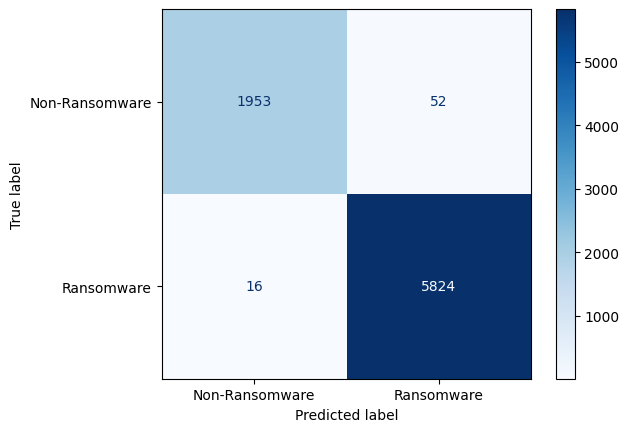

In [14]:


xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train),  # balance weight
    random_state=42,
    eval_metric='logloss'  # suppresses warning
)
# Train and evaluate
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)


print("\n--- XGBoost ---")
print(classification_report(y_test, y_pred, digits=3))

#make matrix more readable
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Non-Ransomware', 'Ransomware']
)
disp.plot(cmap='Blues', values_format='d')

scores = cross_val_score(xgb, X, y, cv=5, scoring='f1')
print("Cross-val F1 mean:", scores.mean())


##### ------- SVM ------

In [13]:
#------ SVM -------


#Only need to scale data for SVM model 
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

svm_model = SVC(kernel='rbf', class_weight='balanced', random_state=42)
svm_model.fit(X_train_scaled, y_train)
print(classification_report(y_test, svm_model.predict(X_test_scaled), digits=3))

              precision    recall  f1-score   support

           0      0.917     0.944     0.930      2005
           1      0.981     0.971     0.976      5840

    accuracy                          0.964      7845
   macro avg      0.949     0.957     0.953      7845
weighted avg      0.964     0.964     0.964      7845

